## Setting everything up

In [1]:
import os
#import iris
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
#import cartopy.crs as ccrs
import matplotlib.pyplot as plt
#from fbprophet import Prophet

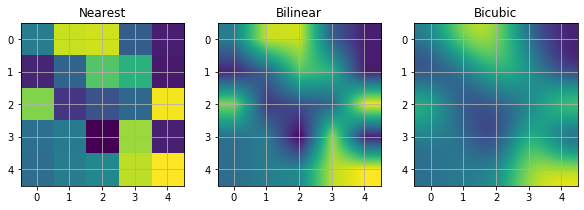

In [15]:
# test subplots combines
A = np.random.rand(5, 5)

fig, axs = plt.subplots(1, 3, figsize=(10, 3))
for ax, interp in zip(axs, ['nearest', 'bilinear', 'bicubic']):
    ax.imshow(A, interpolation=interp)
    ax.set_title(interp.capitalize())
    ax.grid(True)

plt.show()

In [32]:
def test_plot(A,B,tit,ax=None):
    ax=ax
    plt.scatter(A,B)
    plt.ylabel('A')
    plt.xlabel('B')
    plt.title(tit)
    plt.show()

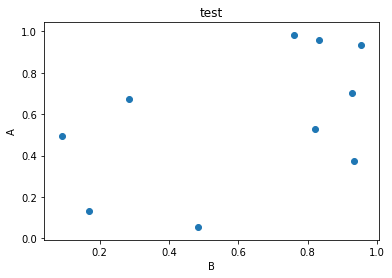

In [30]:
A=np.random.rand(10)
B=np.random.rand(10)
test_plot(A,B,'test')

In [2]:
def test_plot2(A,B,tit,ax1=None,ax2=None):
    ax1=ax1
    ax2=ax2
    ax1.plot(A,B)
    ax2.scatter(A,B)
    ax1.set_xlabel('A')
    ax1.axvline(x=0.5)
    ax1.set_xlim(0, 2)
    ax1.set_title(tit)
    ax2.set_xlabel('A')
    ax2.axvline(x=0.5)
    ax2.set_xlim(0, 2)
    ax2.set_title(tit)

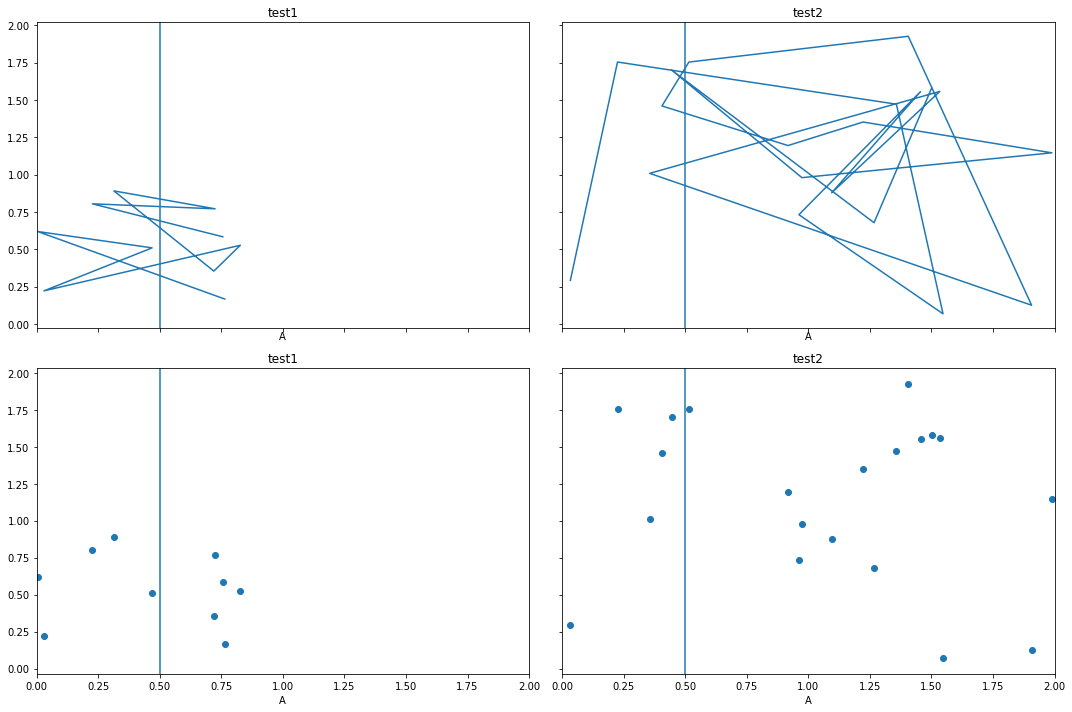

In [3]:
A1=np.random.rand(10)
B1=np.random.rand(10)
A2=np.random.rand(20)*2
B2=np.random.rand(20)*2
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,sharex='col', sharey='row',figsize=(15,10))
test_plot2(A1,B1,'test1',ax1,ax3)
test_plot2(A2,B2,'test2',ax2,ax4)
fig.tight_layout()
plt.show()

## Functions for executions

### Phi-effective

In [4]:
## Basics
# sepearate into 5-yearly like Ivan's format, Dec-March 
def year_separator(year,month,ymin,ymax):
    return ((year < ymax) & (year > ymin)) | ((year == ymax) & (month <= 2)) | ((year == ymin) & (month >=12))

In [3]:
### Phi-Effective
#Reanalysis

def phi_eff_part1(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_eff_lat_demeaned_shifted.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

    # 1950-1979
    dlist=[1950,1955,1960,1965,1970]
    sddf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return sddf,skdf

In [4]:
# post-79
def phi_eff_part2(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1979_2021_eff_lat_demeaned_shifted.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

    # 1979-2021
    dlist=[1980,1985,1990,1995,2000,2005,2010,2015]
    sddf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return sddf,skdf

In [5]:
# models
# Compile and loop around different models
def phi_eff_models(lonsel,latsel):
    flist=['CESM2','MPI','GFDL','IPSL']
    lp=1
    for z in flist:
        print(z)
        print('closest value')
        # closest value definition
        dataall=xr.load_dataset('/project2/moyer/jetstream/cmip6_processed_data/post_processing_output/'+z+'_eff_lat_demeaned_shifted.nc4')
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        given_value=latsel
        lat_closest_value = min(dataall.to_dataframe().reset_index().lat.unique(), key=absolute_difference_function)
        print(lat_closest_value)
        given_value=lonsel
        lon_closest_value = min(dataall.to_dataframe().reset_index().lon.unique(), key=absolute_difference_function)
        print(lon_closest_value)
        
        # drop year 2100 with all zeros 
        dataall=dataall.sel(time=(dataall['time.year']!=2100))
    
        # select Chicago and compute standard deviation and skewness by 5-year, appending them all together
        dlist=[2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095]
        sddf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
        skdf=pd.DataFrame(columns = ['winter','phi_eq_prime','lat','lon','year','month'])
        for x in dlist:
            print(x)
            # read into the 5-year interval
            data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
            select=data.sel(lon=lon_closest_value)
            select=select.sel(lat=lat_closest_value)
            select=select.to_dataframe().reset_index()
            select['year']=select.time.dt.year
            select['month']=select.time.dt.month
            select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
            # assign by winter
            select['winter']=select['year']
            mask=select.month<=3
            select.loc[mask, 'winter'] = select['year']-1
            sdyear=select.groupby(['winter']).std().reset_index(drop=False)
            skyear=select.groupby(['winter']).skew().reset_index(drop=False)
            sddf=sddf.append(sdyear, sort=True)
            skdf=skdf.append(skyear, sort=True)
          
        # output as individual datasets
        globals()['sddf%s' % lp] = sddf
        globals()['skdf%s' % lp] = skdf
        lp=lp+1
        
    # return
    return sddf1,skdf1,sddf2,skdf2,sddf3,skdf3,sddf4,skdf4

In [12]:
## plotting phi_eff banquet, sd and skew
def phi_eff_plots(lonsel,latsel,ax1=None,ax2=None):
    ax1=ax1
    ax2=ax2
    
    sddf_pre1,skdf_pre1=phi_eff_part1(lonsel,latsel)
    sddf_pre1['decade']=(np.floor((sddf_pre1['winter']-1950)/5)+1)*5+1945
    sdsum_pre1=sddf_pre1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre1['decade']=(np.floor((skdf_pre1['winter']-1950)/5)+1)*5+1945
    sksum_pre1=skdf_pre1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum_pre1.columns=sdsum_pre1.columns.droplevel()
    sdsum_pre1=sdsum_pre1.reset_index()
    sksum_pre1.columns=sksum_pre1.columns.droplevel()
    sksum_pre1=sksum_pre1.reset_index()
    
    sddf_pre2,skdf_pre2=phi_eff_part2(lonsel,latsel)
    sddf_pre2['decade']=(np.floor((sddf_pre2['winter']-1980)/5)+1)*5+1975
    sdsum_pre2=sddf_pre2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre2['decade']=(np.floor((skdf_pre2['winter']-1980)/5)+1)*5+1975
    sksum_pre2=skdf_pre2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum_pre2.columns=sdsum_pre2.columns.droplevel()
    sdsum_pre2=sdsum_pre2.reset_index()
    sksum_pre2.columns=sksum_pre2.columns.droplevel()
    sksum_pre2=sksum_pre2.reset_index()
    
    sddf1,skdf1,sddf2,skdf2,sddf3,skdf3,sddf4,skdf4=phi_eff_models(lonsel,latsel)
    sddf1['decade']=(np.floor((sddf1['winter']-2015)/5)+1)*5+2010
    sddf2['decade']=(np.floor((sddf2['winter']-2015)/5)+1)*5+2010
    sddf3['decade']=(np.floor((sddf3['winter']-2015)/5)+1)*5+2010
    sddf4['decade']=(np.floor((sddf4['winter']-2015)/5)+1)*5+2010
    skdf1['decade']=(np.floor((skdf1['winter']-2015)/5)+1)*5+2010
    skdf2['decade']=(np.floor((skdf2['winter']-2015)/5)+1)*5+2010
    skdf3['decade']=(np.floor((skdf3['winter']-2015)/5)+1)*5+2010
    skdf4['decade']=(np.floor((skdf4['winter']-2015)/5)+1)*5+2010

    sdsum1=sddf1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum2=sddf2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum3=sddf3[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum4=sddf4[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum1=skdf1[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum2=skdf2[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum3=skdf3[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum4=skdf4[['phi_eq_prime','decade']].groupby(['decade']).agg(['mean','min','max'])

    sdsum1.columns=sdsum1.columns.droplevel()
    sdsum1=sdsum1.reset_index()
    sdsum2.columns=sdsum2.columns.droplevel()
    sdsum2=sdsum2.reset_index()
    sdsum3.columns=sdsum3.columns.droplevel()
    sdsum3=sdsum3.reset_index()
    sdsum4.columns=sdsum4.columns.droplevel()
    sdsum4=sdsum4.reset_index()
    
    sksum1.columns=sksum1.columns.droplevel()
    sksum1=sksum1.reset_index()
    sksum2.columns=sksum2.columns.droplevel()
    sksum2=sksum2.reset_index()
    sksum3.columns=sksum3.columns.droplevel()
    sksum3=sksum3.reset_index()
    sksum4.columns=sksum4.columns.droplevel()
    sksum4=sksum4.reset_index()

    #return sdsum_pre1,sdsum_pre2,sdsum1,sdsum2,sdsum3,sdsum4
    
    ## plotting
    # plot std
    ax1.plot(sdsum_pre1.decade, sdsum_pre1['mean'], label="_nolegend_", color="black")
    ax1.fill_between(sdsum_pre1.decade, sdsum_pre1['min'], sdsum_pre1['max'], alpha=0.1, color="black")
    ax1.plot(sdsum_pre2.decade, sdsum_pre2['mean'], label='_nolegend_', color="black")
    ax1.fill_between(sdsum_pre2.decade, sdsum_pre2['min'], sdsum_pre2['max'], alpha=0.1, color="black")

    ax1.plot(sdsum1.decade, sdsum1['mean'], label="_nolegend_", color="red")
    ax1.fill_between(sdsum1.decade, sdsum1['min'], sdsum1['max'], alpha=0.1, color="red")

    ax1.plot(sdsum2.decade, sdsum2['mean'], label="_nolegend_", color="blue")
    ax1.fill_between(sdsum2.decade, sdsum2['min'], sdsum2['max'], alpha=0.1, color="blue")

    ax1.plot(sdsum3.decade, sdsum3['mean'], label="_nolegend_", color="orange")
    ax1.fill_between(sdsum3.decade, sdsum3['min'], sdsum3['max'], alpha=0.1, color="orange")

    ax1.plot(sdsum4.decade, sdsum4['mean'], label="_nolegend_", color="green")
    ax1.fill_between(sdsum4.decade, sdsum4['min'], sdsum4['max'], alpha=0.1, color="green")

    ax1.axvline(x=2015)
    ax1.set_xlim(1950, 2095)
    
    ax1.set_ylabel('Deg')
    ax1.set_xlabel('year')
    ax1.set_title('STD of eff. lat.')

    # plot skewness
    ax2.plot(sksum_pre1.decade, sksum_pre1['mean'], label="_nolegend_", color="black")
    ax2.fill_between(sksum_pre1.decade, sksum_pre1['min'], sksum_pre1['max'], alpha=0.1, color="black")
    ax2.plot(sksum_pre2.decade, sksum_pre2['mean'], label='_nolegend_', color="black")
    ax2.fill_between(sksum_pre2.decade, sksum_pre2['min'], sksum_pre2['max'], alpha=0.1, color="black")

    ax2.plot(sksum1.decade, sksum1['mean'], label="_nolegend_", color="red")
    ax2.fill_between(sksum1.decade, sksum1['min'], sksum1['max'], alpha=0.1, color="red")

    ax2.plot(sksum2.decade, sksum2['mean'], label="_nolegend_", color="blue")
    ax2.fill_between(sksum2.decade, sksum2['min'], sksum2['max'], alpha=0.1, color="blue")

    ax2.plot(sksum3.decade, sksum3['mean'], label="_nolegend_", color="orange")
    ax2.fill_between(sksum3.decade, sksum3['min'], sksum3['max'], alpha=0.1, color="orange")

    ax2.plot(sksum4.decade, sksum4['mean'], label="_nolegend_", color="green")
    ax2.fill_between(sksum4.decade, sksum4['min'], sksum4['max'], alpha=0.1, color="green")

    ax2.axvline(x=2015)
    ax2.set_xlim(1950, 2095)
    
    ax2.set_ylabel('Deg')
    ax2.set_xlabel('year')
    ax2.set_title('Skewness of eff. lat.')


In [ ]:
# Output dataset for use


### Demean T-prime

In [7]:
#Reanalysis

def dm_t_prime_part1(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

    # 1950-1979
    dlist=[1950,1955,1960,1965,1970]
    sddf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return sddf,skdf

In [8]:
# post-79
def dm_t_prime_part2(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1979_2021_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)

    # 1979-2021
    dlist=[1980,1985,1990,1995,2000,2005,2010,2015]
    sddf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
    for x in dlist:
        print(x)
        data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select=select.to_dataframe().reset_index()
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return sddf,skdf

In [9]:
# models
# Compile and loop around different models
def dm_t_prime_models(lonsel,latsel):
    flist=['CESM2','MPI','GFDL','IPSL']
    lp=1
    for z in flist:
        print(z)
        print('closest value')
        # closest value definition
        dataall=xr.load_dataset('/project2/moyer/jetstream/cmip6_processed_data/post_processing_output/'+z+'_t_prime_demeaned.nc4')
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        given_value=latsel
        lat_closest_value = min(dataall.to_dataframe().reset_index().lat.unique(), key=absolute_difference_function)
        print(lat_closest_value)
        given_value=lonsel
        lon_closest_value = min(dataall.to_dataframe().reset_index().lon.unique(), key=absolute_difference_function)
        print(lon_closest_value)
        
        # drop year 2100 with all zeros 
        dataall=dataall.sel(time=(dataall['time.year']!=2100))
    
        # select Chicago and compute standard deviation and skewness by 5-year, appending them all together
        dlist=[2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095]
        sddf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
        skdf=pd.DataFrame(columns = ['winter','dm_t_prime','lat','lon','year','month'])
        for x in dlist:
            print(x)
            # read into the 5-year interval
            data=dataall.sel(time=year_separator(dataall['time.year'],dataall['time.month'],x,x+5))
            select=data.sel(lon=lon_closest_value)
            select=select.sel(lat=lat_closest_value)
            select=select.to_dataframe().reset_index()
            select['year']=select.time.dt.year
            select['month']=select.time.dt.month
            select=select.loc[(select['month'] == 1) | (select['month'] == 2) | (select['month'] == 12)]
            # assign by winter
            select['winter']=select['year']
            mask=select.month<=3
            select.loc[mask, 'winter'] = select['year']-1
            sdyear=select.groupby(['winter']).std().reset_index(drop=False)
            skyear=select.groupby(['winter']).skew().reset_index(drop=False)
            sddf=sddf.append(sdyear, sort=True)
            skdf=skdf.append(skyear, sort=True)
          
        # output as individual datasets
        globals()['sddf%s' % lp] = sddf
        globals()['skdf%s' % lp] = skdf
        lp=lp+1
        
    # return
    return sddf1,skdf1,sddf2,skdf2,sddf3,skdf3,sddf4,skdf4

In [15]:
## plotting phi_eff banquet, sd and skew
def dm_t_prime_plots(lonsel,latsel,ax1=None,ax2=None):
    ax1=ax1
    ax2=ax2
    
    sddf_pre1,skdf_pre1=dm_t_prime_part1(lonsel,latsel)
    sddf_pre1['decade']=(np.floor((sddf_pre1['winter']-1950)/5)+1)*5+1945
    sdsum_pre1=sddf_pre1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre1['decade']=(np.floor((skdf_pre1['winter']-1950)/5)+1)*5+1945
    sksum_pre1=skdf_pre1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum_pre1.columns=sdsum_pre1.columns.droplevel()
    sdsum_pre1=sdsum_pre1.reset_index()
    sksum_pre1.columns=sksum_pre1.columns.droplevel()
    sksum_pre1=sksum_pre1.reset_index()
    
    sddf_pre2,skdf_pre2=dm_t_prime_part2(lonsel,latsel)
    sddf_pre2['decade']=(np.floor((sddf_pre2['winter']-1980)/5)+1)*5+1975
    sdsum_pre2=sddf_pre2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre2['decade']=(np.floor((skdf_pre2['winter']-1980)/5)+1)*5+1975
    sksum_pre2=skdf_pre2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum_pre2.columns=sdsum_pre2.columns.droplevel()
    sdsum_pre2=sdsum_pre2.reset_index()
    sksum_pre2.columns=sksum_pre2.columns.droplevel()
    sksum_pre2=sksum_pre2.reset_index()
    
    sddf1,skdf1,sddf2,skdf2,sddf3,skdf3,sddf4,skdf4=dm_t_prime_models(lonsel,latsel)
    sddf1['decade']=(np.floor((sddf1['winter']-2015)/5)+1)*5+2010
    sddf2['decade']=(np.floor((sddf2['winter']-2015)/5)+1)*5+2010
    sddf3['decade']=(np.floor((sddf3['winter']-2015)/5)+1)*5+2010
    sddf4['decade']=(np.floor((sddf4['winter']-2015)/5)+1)*5+2010
    skdf1['decade']=(np.floor((skdf1['winter']-2015)/5)+1)*5+2010
    skdf2['decade']=(np.floor((skdf2['winter']-2015)/5)+1)*5+2010
    skdf3['decade']=(np.floor((skdf3['winter']-2015)/5)+1)*5+2010
    skdf4['decade']=(np.floor((skdf4['winter']-2015)/5)+1)*5+2010

    sdsum1=sddf1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum2=sddf2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum3=sddf3[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum4=sddf4[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum1=skdf1[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum2=skdf2[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum3=skdf3[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum4=skdf4[['dm_t_prime','decade']].groupby(['decade']).agg(['mean','min','max'])

    sdsum1.columns=sdsum1.columns.droplevel()
    sdsum1=sdsum1.reset_index()
    sdsum2.columns=sdsum2.columns.droplevel()
    sdsum2=sdsum2.reset_index()
    sdsum3.columns=sdsum3.columns.droplevel()
    sdsum3=sdsum3.reset_index()
    sdsum4.columns=sdsum4.columns.droplevel()
    sdsum4=sdsum4.reset_index()
    
    sksum1.columns=sksum1.columns.droplevel()
    sksum1=sksum1.reset_index()
    sksum2.columns=sksum2.columns.droplevel()
    sksum2=sksum2.reset_index()
    sksum3.columns=sksum3.columns.droplevel()
    sksum3=sksum3.reset_index()
    sksum4.columns=sksum4.columns.droplevel()
    sksum4=sksum4.reset_index()

    #return sdsum_pre1,sdsum_pre2,sdsum1,sdsum2,sdsum3,sdsum4
    
    ## plotting
    # plot std
    ax1.plot(sdsum_pre1.decade, sdsum_pre1['mean'], label="_nolegend_", color="black")
    ax1.fill_between(sdsum_pre1.decade, sdsum_pre1['min'], sdsum_pre1['max'], alpha=0.1, color="black")
    ax1.plot(sdsum_pre2.decade, sdsum_pre2['mean'], label='_nolegend_', color="black")
    ax1.fill_between(sdsum_pre2.decade, sdsum_pre2['min'], sdsum_pre2['max'], alpha=0.1, color="black")

    ax1.plot(sdsum1.decade, sdsum1['mean'], label="_nolegend_", color="red")
    ax1.fill_between(sdsum1.decade, sdsum1['min'], sdsum1['max'], alpha=0.1, color="red")

    ax1.plot(sdsum2.decade, sdsum2['mean'], label="_nolegend_", color="blue")
    ax1.fill_between(sdsum2.decade, sdsum2['min'], sdsum2['max'], alpha=0.1, color="blue")

    ax1.plot(sdsum3.decade, sdsum3['mean'], label="_nolegend_", color="orange")
    ax1.fill_between(sdsum3.decade, sdsum3['min'], sdsum3['max'], alpha=0.1, color="orange")

    ax1.plot(sdsum4.decade, sdsum4['mean'], label="_nolegend_", color="green")
    ax1.fill_between(sdsum4.decade, sdsum4['min'], sdsum4['max'], alpha=0.1, color="green")

    ax1.axvline(x=2015)
    ax1.set_xlim(1950, 2095)
    
    ax1.set_ylabel('Kelvin')
    ax1.set_xlabel('year')
    ax1.set_title('STD of demeaned T')
    
    # plot skewness
    ax2.plot(sksum_pre1.decade, sksum_pre1['mean'], label="_nolegend_", color="black")
    ax2.fill_between(sksum_pre1.decade, sksum_pre1['min'], sksum_pre1['max'], alpha=0.1, color="black")
    ax2.plot(sksum_pre2.decade, sksum_pre2['mean'], label='_nolegend_', color="black")
    ax2.fill_between(sksum_pre2.decade, sksum_pre2['min'], sksum_pre2['max'], alpha=0.1, color="black")

    ax2.plot(sksum1.decade, sksum1['mean'], label="_nolegend_", color="red")
    ax2.fill_between(sksum1.decade, sksum1['min'], sksum1['max'], alpha=0.1, color="red")

    ax2.plot(sksum2.decade, sksum2['mean'], label="_nolegend_", color="blue")
    ax2.fill_between(sksum2.decade, sksum2['min'], sksum2['max'], alpha=0.1, color="blue")

    ax2.plot(sksum3.decade, sksum3['mean'], label="_nolegend_", color="orange")
    ax2.fill_between(sksum3.decade, sksum3['min'], sksum3['max'], alpha=0.1, color="orange")

    ax2.plot(sksum4.decade, sksum4['mean'], label="_nolegend_", color="green")
    ax2.fill_between(sksum4.decade, sksum4['min'], sksum4['max'], alpha=0.1, color="green")

    ax2.axvline(x=2015)
    ax2.set_xlim(1950, 2095)
    
    ax2.set_ylabel('Kelvin')
    ax2.set_xlabel('year')
    ax2.set_title('Skewness of demeaned T')


closest value
42.0
-87.5
1950
1955
1960
1965
1970
closest value
42.0
-87.5
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
41.93717277486911
-87.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
41.61021795745573
-87.1875
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
41.5
-88.125
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
41.83098602294922
-87.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
closest value
42.0
-87.5
1950
1955
1960
1965
1970
closest value
42.0
-87.5
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
41.93717277486911
-87.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
41.61021795745573
-87.1875
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
cl

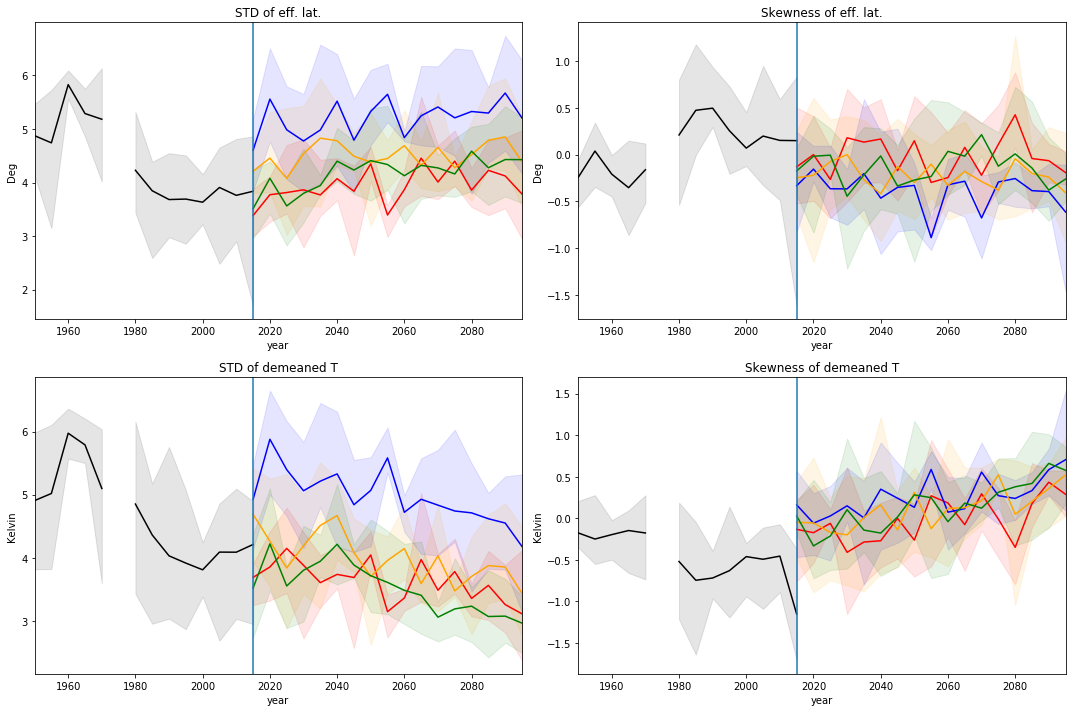

In [20]:
# Chicago: 42N, 87.5W
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))
phi_eff_plots(-87.5,42,ax1,ax2)
dm_t_prime_plots(-87.5,42,ax3,ax4)
fig.tight_layout()
plt.show()

closest value
41.0
111.75
1950
1955
1960
1965
1970
closest value
41.0
111.75
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
40.994764397905755
111.25
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
40.67515858430462
111.5625
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
40.5
111.875
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
40.56338119506836
112.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


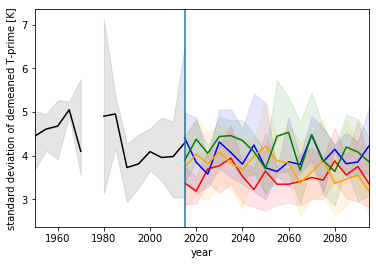

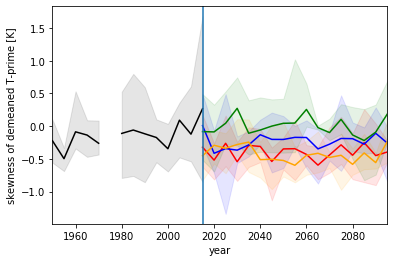

In [94]:
# Hohhot: 41N, 111.75E
dm_t_prime_plots(111.75,41)

closest value
75.0
40.5
1950
1955
1960
1965
1970
closest value
75.0
40.5
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
74.92146596858638
40.0
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
75.2719921848602
40.3125
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
74.5
40.625
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
74.78873443603516
40.0
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


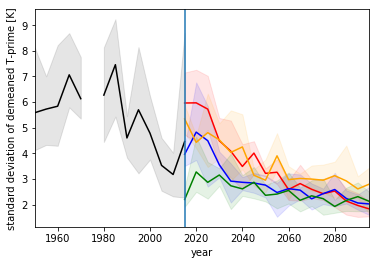

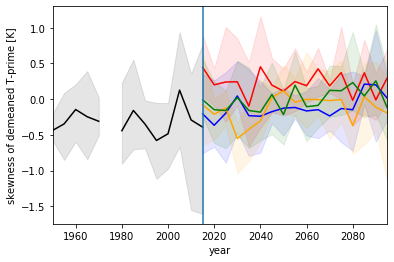

In [95]:
# Barent Sea: 75N, 40.5E
dm_t_prime_plots(40.5,75)

closest value
41.5
179.5
1950
1955
1960
1965
1970
closest value
41.5
179.5
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
41.93717277486911
178.75
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
41.61021795745573
179.0625
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
41.5
179.375
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
41.83098602294922
177.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


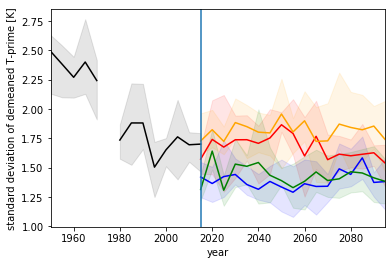

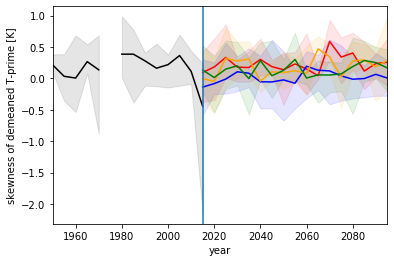

In [96]:
# Pacific: 41.5N, 179.5E
dm_t_prime_plots(179.5,41.5)

closest value
71.75
-42.5
1950
1955
1960
1965
1970
closest value
71.75
-42.5
1980
1985
1990
1995
2000
2005
2010
2015
CESM2
closest value
72.09424083769633
-42.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
71.53188891182717
-42.1875
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
71.5
-43.125
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
72.25352478027344
-42.5
2015
2020
2025
2030
2035
2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


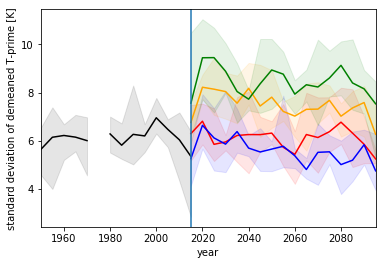

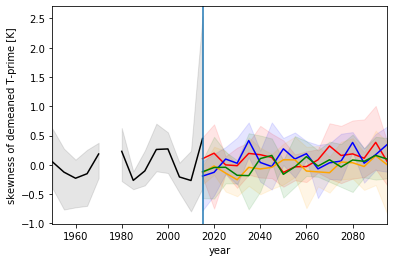

In [97]:
# Greenland: 71.75N, 42.5W
dm_t_prime_plots(-42.5,71.75)

## Perform the same plot for demeaned T directly

In [2]:
# load Amanda Function
from jetstream.post_proc import SingleModelPostProcessor

In [3]:
## Basics
# sepearate into 5-yearly like Ivan's format, Dec-March 
def year_separator(year,month,ymin,ymax):
    return ((year < ymax) & (year > ymin)) | ((year == ymax) & (month <= 2)) | ((year == ymin) & (month >=12))

In [4]:
# Models run functions
# Compile and loop around different models
def dm_t_models(lonsel,latsel):
    mlist = ["CESM2-WACCM","MPI-ESM1-2-HR","GFDL-ESM4","IPSL-CM6A-LR"]
    #mlist = ["CESM2-WACCM"]
    flist=['CESM2','MPI','GFDL','IPSL']
    #flist=['CESM2']
    lp=1
    for i in range(0,4):
        z=flist[i]
        print(z)
        print('closest value')
        # closest value definition
        dataall=xr.load_dataset('/project2/moyer/jetstream/cmip6_processed_data/post_processing_output/'+z+'_t_prime_demeaned.nc4')
        absolute_difference_function = lambda list_value : abs(list_value - given_value)
        given_value=latsel
        lat_closest_value = min(dataall.to_dataframe().reset_index().lat.unique(), key=absolute_difference_function)
        print(lat_closest_value)
        given_value=lonsel
        lon_closest_value = min(dataall.to_dataframe().reset_index().lon.unique(), key=absolute_difference_function)
        print(lon_closest_value)
        
        # read into the raw temperature datas
        dlist=[2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095]
        def iswinter(month):
            return (month == 1) | (month == 2) | (month == 12)
        for x in dlist:
            data=xr.load_dataset('/project2/moyer/jetstream/cmip6_processed_data/'+mlist[i]+'_ssp585_tas_daily/'+mlist[i]+'_ssp585_tas_daily_t_prime_'+str(x)+'-11-01_'+str(x+5)+'-03-01.nc4')
            select=data.sel(lon=lon_closest_value)
            select=select.sel(lat=lat_closest_value)
            select = select.sel(time=iswinter(select['time.month']))
            # expand dimension
            select = select.expand_dims(["lon","lat"])
            # concat
            if x==2015:
                dataall=select
            else:
                dataall = xr.combine_by_coords([dataall, select])
                
        # drop year 2100 with all zeros 
        dataall=dataall.sel(time=(dataall['time.year']!=2100)) 
        
        print('data loaded')
        
        # demeaning
        dm_dataall = SingleModelPostProcessor.demean(dataall.tas,decade=True)
        dm_dataall = dm_dataall.to_dataframe().reset_index()
       
        # select Chicago and compute standard deviation and skewness by 5-year, appending them all together
        dlist=[2015,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095]
        sddf=pd.DataFrame(columns = ['winter','tas','lat','lon','year','month'])
        skdf=pd.DataFrame(columns = ['winter','tas','lat','lon','year','month'])
        for x in dlist:
            print(x)
            # read into the 5-year interval
            select=dm_dataall[year_separator(dm_dataall.time.dt.year,dm_dataall.time.dt.month,x,x+5)]
            select['year']=select.time.dt.year
            select['month']=select.time.dt.month
            # assign by winter
            select['winter']=select['year']
            mask=select.month<=3
            select.loc[mask, 'winter'] = select['year']-1
            sdyear=select.groupby(['winter']).std().reset_index(drop=False)
            skyear=select.groupby(['winter']).skew().reset_index(drop=False)
            sddf=sddf.append(sdyear, sort=True)
            skdf=skdf.append(skyear, sort=True)
          
        # output as individual datasets
        globals()['sddf%s' % lp] = sddf
        globals()['skdf%s' % lp] = skdf
        lp=lp+1
        
    # return
    return sddf1,skdf1,sddf2,skdf2,sddf3,skdf3,sddf4,skdf4


In [5]:
#Reanalysis
# 50-79
def dm_t_reanalysis1(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1950_1979_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)
    
    # read into the raw temperature datas
    dlist=[1950,1955,1960,1965,1970]
    def iswinter(month):
        return (month == 1) | (month == 2) | (month == 12)
    for x in dlist:
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1950_1979_lat_20_1D_rename/ds_1950_1979_lat_20_1D_rename_t_prime_'+str(x)+'-12-01_'+str(x+5)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select = select.sel(time=iswinter(select['time.month']))
        # concat
        if x==1950:
            dataall=select
        else:
            dataall = xr.combine_by_coords([dataall, select])
                
    print('data loaded')
        
    # demeaning
    dm_dataall = SingleModelPostProcessor.demean(dataall.t2m,decade=True)
    dm_dataall = dm_dataall.to_dataframe().reset_index()

    # 1950-1979
    dlist=[1950,1955,1960,1965,1970]
    sddf=pd.DataFrame(columns = ['winter','t2m','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','t2m','lat','lon','year','month'])
    for x in dlist:
        print(x)
        select=dm_dataall[year_separator(dm_dataall.time.dt.year,dm_dataall.time.dt.month,x,x+5)]
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return sddf,skdf

In [6]:
#Reanalysis
# 79-20
def dm_t_reanalysis2(lonsel,latsel):
    print('closest value')
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    dataall=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/post_processing_output/era5_1979_2021_t_prime_demeaned.nc4')
    given_value=latsel
    lat_closest_value = min(dataall.coords['lat'].to_dataframe().lat.unique(), key=absolute_difference_function)
    print(lat_closest_value)
    given_value=lonsel
    lon_closest_value = min(dataall.coords['lon'].to_dataframe().lon.unique(), key=absolute_difference_function)
    print(lon_closest_value)
    
    # read into the raw temperature datas
    x1list=[1979,1984,1986,1988]
    x2list=[1984,1986,1988,1990]
    def iswinter(month):
        return (month == 1) | (month == 2) | (month == 12)
    for i in range(0,4):
        x1=x1list[i]
        x2=x2list[i]
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed/ds_1979_2021_lat_20_1D_renamed_t_prime_'+str(x1)+'-12-01_'+str(x2)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select = select.sel(time=iswinter(select['time.month']))
        # concat
        if x1==1979:
            dataall=select
        else:
            dataall = xr.combine_by_coords([dataall, select])
    
    for y in range(1990,2020):
        data=xr.load_dataset('/project2/moyer/jetstream/era5_processed_data/ds_1979_2021_lat_20_1D_renamed/ds_1979_2021_lat_20_1D_renamed_t_prime_'+str(y)+'-12-01_'+str(y+1)+'-03-01.nc4')
        select=data.sel(lon=lon_closest_value)
        select=select.sel(lat=lat_closest_value)
        select = select.sel(time=iswinter(select['time.month']))
        # concat
        dataall = xr.combine_by_coords([dataall, select])
                
    print('data loaded')
        
    # demeaning
    dm_dataall = SingleModelPostProcessor.demean(dataall.t2m,decade=True)
    dm_dataall = dm_dataall.to_dataframe().reset_index()

    # 1979-2021
    dlist=[1980,1985,1990,1995,2000,2005,2010,2015]
    sddf=pd.DataFrame(columns = ['winter','t2m','lat','lon','year','month'])
    skdf=pd.DataFrame(columns = ['winter','t2m','lat','lon','year','month'])
    for x in dlist:
        print(x)
        select=dm_dataall[year_separator(dm_dataall.time.dt.year,dm_dataall.time.dt.month,x,x+5)]
        select['year']=select.time.dt.year
        select['month']=select.time.dt.month
        # assign by winter
        select['winter']=select['year']
        mask=select.month<=3
        select.loc[mask, 'winter'] = select['year']-1
        sdyear=select.groupby(['winter']).std().reset_index(drop=False)
        skyear=select.groupby(['winter']).skew().reset_index(drop=False)
        sddf=sddf.append(sdyear, sort=True)
        skdf=skdf.append(skyear, sort=True)
    return sddf,skdf

In [7]:
## plotting phi_eff banquet, sd and skew
def dm_t_plots(lonsel,latsel):
    sddf_pre1,skdf_pre1=dm_t_reanalysis1(lonsel,latsel)
    sddf_pre1['decade']=(np.floor((sddf_pre1['winter']-1950)/5)+1)*5+1945
    sdsum_pre1=sddf_pre1[['t2m','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre1['decade']=(np.floor((skdf_pre1['winter']-1950)/5)+1)*5+1945
    sksum_pre1=skdf_pre1[['t2m','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum_pre1.columns=sdsum_pre1.columns.droplevel()
    sdsum_pre1=sdsum_pre1.reset_index()
    sksum_pre1.columns=sksum_pre1.columns.droplevel()
    sksum_pre1=sksum_pre1.reset_index()
    
    sddf_pre2,skdf_pre2=dm_t_reanalysis2(lonsel,latsel)
    sddf_pre2['decade']=(np.floor((sddf_pre2['winter']-1980)/5)+1)*5+1975
    sdsum_pre2=sddf_pre2[['t2m','decade']].groupby(['decade']).agg(['mean','min','max'])
    skdf_pre2['decade']=(np.floor((skdf_pre2['winter']-1980)/5)+1)*5+1975
    sksum_pre2=skdf_pre2[['t2m','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum_pre2.columns=sdsum_pre2.columns.droplevel()
    sdsum_pre2=sdsum_pre2.reset_index()
    sksum_pre2.columns=sksum_pre2.columns.droplevel()
    sksum_pre2=sksum_pre2.reset_index()
    
    sddf1,skdf1,sddf2,skdf2,sddf3,skdf3,sddf4,skdf4=dm_t_models(lonsel,latsel)
    sddf1['decade']=(np.floor((sddf1['winter']-2015)/5)+1)*5+2010
    sddf2['decade']=(np.floor((sddf2['winter']-2015)/5)+1)*5+2010
    sddf3['decade']=(np.floor((sddf3['winter']-2015)/5)+1)*5+2010
    sddf4['decade']=(np.floor((sddf4['winter']-2015)/5)+1)*5+2010
    skdf1['decade']=(np.floor((skdf1['winter']-2015)/5)+1)*5+2010
    skdf2['decade']=(np.floor((skdf2['winter']-2015)/5)+1)*5+2010
    skdf3['decade']=(np.floor((skdf3['winter']-2015)/5)+1)*5+2010
    skdf4['decade']=(np.floor((skdf4['winter']-2015)/5)+1)*5+2010

    sdsum1=sddf1[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum2=sddf2[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum3=sddf3[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])
    sdsum4=sddf4[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum1=skdf1[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum2=skdf2[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum3=skdf3[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])
    sksum4=skdf4[['tas','decade']].groupby(['decade']).agg(['mean','min','max'])

    sdsum1.columns=sdsum1.columns.droplevel()
    sdsum1=sdsum1.reset_index()
    sdsum2.columns=sdsum2.columns.droplevel()
    sdsum2=sdsum2.reset_index()
    sdsum3.columns=sdsum3.columns.droplevel()
    sdsum3=sdsum3.reset_index()
    sdsum4.columns=sdsum4.columns.droplevel()
    sdsum4=sdsum4.reset_index()
    
    sksum1.columns=sksum1.columns.droplevel()
    sksum1=sksum1.reset_index()
    sksum2.columns=sksum2.columns.droplevel()
    sksum2=sksum2.reset_index()
    sksum3.columns=sksum3.columns.droplevel()
    sksum3=sksum3.reset_index()
    sksum4.columns=sksum4.columns.droplevel()
    sksum4=sksum4.reset_index()

    #return sdsum_pre1,sdsum_pre2,sdsum1,sdsum2,sdsum3,sdsum4
    
    ## plotting
    # plot std
    plt.plot(sdsum_pre1.decade, sdsum_pre1['mean'], label="_nolegend_", color="black")
    plt.fill_between(sdsum_pre1.decade, sdsum_pre1['min'], sdsum_pre1['max'], alpha=0.1, color="black")
    plt.plot(sdsum_pre2.decade, sdsum_pre2['mean'], label='_nolegend_', color="black")
    plt.fill_between(sdsum_pre2.decade, sdsum_pre2['min'], sdsum_pre2['max'], alpha=0.1, color="black")

    plt.plot(sdsum1.decade, sdsum1['mean'], label="_nolegend_", color="red")
    plt.fill_between(sdsum1.decade, sdsum1['min'], sdsum1['max'], alpha=0.1, color="red")

    plt.plot(sdsum2.decade, sdsum2['mean'], label="_nolegend_", color="blue")
    plt.fill_between(sdsum2.decade, sdsum2['min'], sdsum2['max'], alpha=0.1, color="blue")

    plt.plot(sdsum3.decade, sdsum3['mean'], label="_nolegend_", color="orange")
    plt.fill_between(sdsum3.decade, sdsum3['min'], sdsum3['max'], alpha=0.1, color="orange")

    plt.plot(sdsum4.decade, sdsum4['mean'], label="_nolegend_", color="green")
    plt.fill_between(sdsum4.decade, sdsum4['min'], sdsum4['max'], alpha=0.1, color="green")

    plt.axvline(x=2015)
    plt.xlim(1950, 2095)
    
    plt.ylabel('standard deviation of demeaned T [K]')
    plt.xlabel('year')

    plt.show()
    
    # plot skewness
    plt.plot(sksum_pre1.decade, sksum_pre1['mean'], label="_nolegend_", color="black")
    plt.fill_between(sksum_pre1.decade, sksum_pre1['min'], sksum_pre1['max'], alpha=0.1, color="black")
    plt.plot(sksum_pre2.decade, sksum_pre2['mean'], label='_nolegend_', color="black")
    plt.fill_between(sksum_pre2.decade, sksum_pre2['min'], sksum_pre2['max'], alpha=0.1, color="black")

    plt.plot(sksum1.decade, sksum1['mean'], label="_nolegend_", color="red")
    plt.fill_between(sksum1.decade, sksum1['min'], sksum1['max'], alpha=0.1, color="red")

    plt.plot(sksum2.decade, sksum2['mean'], label="_nolegend_", color="blue")
    plt.fill_between(sksum2.decade, sksum2['min'], sksum2['max'], alpha=0.1, color="blue")

    plt.plot(sksum3.decade, sksum3['mean'], label="_nolegend_", color="orange")
    plt.fill_between(sksum3.decade, sksum3['min'], sksum3['max'], alpha=0.1, color="orange")

    plt.plot(sksum4.decade, sksum4['mean'], label="_nolegend_", color="green")
    plt.fill_between(sksum4.decade, sksum4['min'], sksum4['max'], alpha=0.1, color="green")

    plt.axvline(x=2015)
    plt.xlim(1950, 2095)
    
    plt.ylabel('skewness of demeaned T [K]')
    plt.xlabel('year')

    plt.show()

closest value
42.0
-87.5
data loaded
1950
1955
1960
1965
1970


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

closest value
42.0
-87.5
data loaded
1980
1985
1990
1995
2000
2005


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2010
2015
CESM2
closest value
41.93717277486911
-87.5
data loaded
2015
2020
2025
2030
2035
2040


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
41.61021795745573
-87.1875
data loaded
2015
2020
2025
2030
2035
2040


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
41.5
-88.125
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
41.83098602294922
-87.5
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


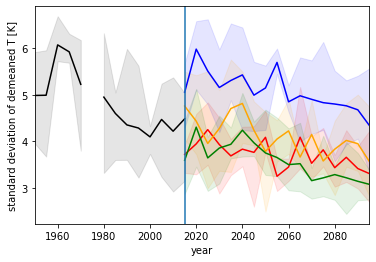

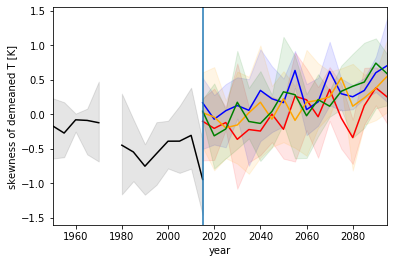

In [40]:
# Chicago: 42N, 87.5W
dm_t_plots(-87.5,42)

closest value
41.0
111.75
data loaded
1950
1955
1960
1965
1970


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

closest value
41.0
111.75
data loaded
1980
1985
1990
1995
2000
2005


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2010
2015
CESM2
closest value
40.994764397905755
111.25
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
40.67515858430462
111.5625
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
40.5
111.875
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
40.56338119506836
112.5
data loaded
2015
2020
2025
2030
2035
2040


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


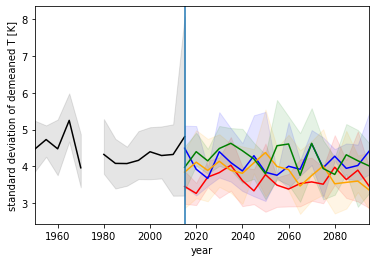

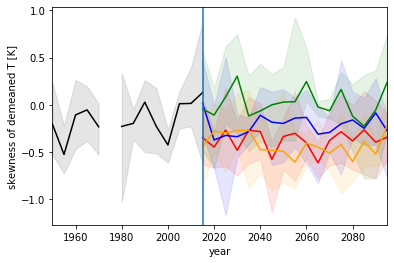

In [41]:
# Hohhot: 41N, 111.75E
dm_t_plots(111.75,41)

closest value
75.0
40.5
data loaded
1950


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

1955
1960
1965
1970
closest value
75.0
40.5
data loaded
1980
1985
1990
1995
2000
2005


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2010
2015
CESM2
closest value
74.92146596858638
40.0
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
75.2719921848602
40.3125
data loaded
2015
2020
2025
2030
2035
2040


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
74.5
40.625
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
74.78873443603516
40.0
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


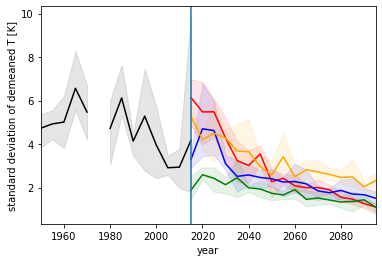

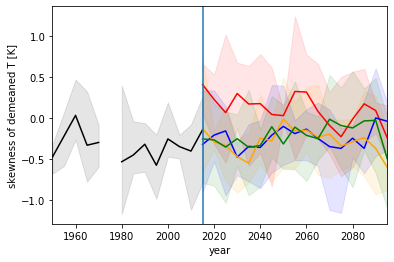

In [8]:
# Barent Sea: 75N, 40.5E
dm_t_plots(40.5,75)

closest value
41.5
179.5
data loaded
1950
1955
1960
1965


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

1970
closest value
41.5
179.5
data loaded
1980
1985
1990
1995
2000
2005


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2010
2015
CESM2
closest value
41.93717277486911
178.75
data loaded
2015
2020
2025
2030
2035
2040


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
41.61021795745573
179.0625
data loaded
2015
2020
2025
2030
2035
2040


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
41.5
179.375
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
41.83098602294922
177.5
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


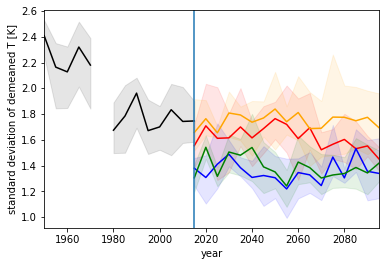

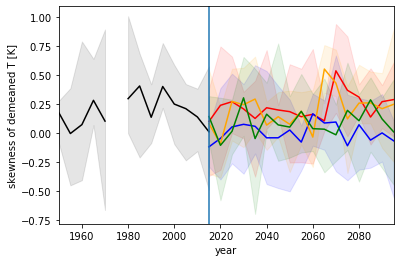

In [9]:
# Pacific: 41.5N, 179.5E
dm_t_plots(179.5,41.5)

closest value
71.75
-42.5
data loaded
1950
1955
1960
1965
1970


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

closest value
71.75
-42.5
data loaded
1980
1985
1990


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

1995
2000
2005
2010
2015
CESM2
closest value
72.09424083769633
-42.5
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
MPI
closest value
71.53188891182717
-42.1875
data loaded
2015
2020
2025
2030
2035


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2040
2045
2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
GFDL
closest value
71.5
-43.125
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095
IPSL
closest value
72.25352478027344
-42.5
data loaded
2015
2020
2025
2030
2035
2040
2045


/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/yuqisong/.local/lib/python3.7/site-packages/ipykernel_launcher.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pand

2050
2055
2060
2065
2070
2075
2080
2085
2090
2095


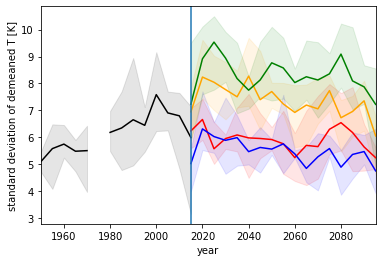

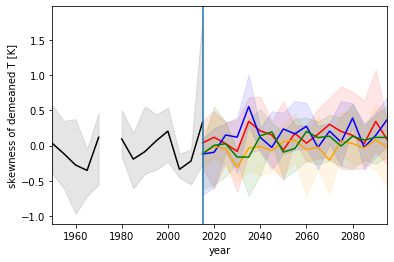

In [10]:
# Greenland: 71.75N, 42.5W
dm_t_plots(-42.5,71.75)